In [1]:
# Import modules to be utilised later, see programming paradigm section of assessment for usage
# Commit testing 290403
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
from scipy.stats import poisson
from scipy.stats import norm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.formula.api import ols
# use magic command to ensure plots can be displayed inline
%matplotlib inline

# Data Understanding / Preparation

# Section 1. Preparation for BASE

In [2]:
# Determine file encoding format to ensure we can read this date into a dataframe
with open('DCC_DUBLINK_BASE.csv') as file:
    print(file)

<_io.TextIOWrapper name='DCC_DUBLINK_BASE.csv' mode='r' encoding='cp1252'>


In [3]:
# observing this datafile we view observations and features
df = pd.read_csv ("DCC_DUBLINK_BASE.csv", encoding='cp1252', skiprows=[1])
df.shape


(72160, 10)

In [4]:
# list all the features of the datset
print (df.columns.values)

['REG_REF' 'APPDATE' 'PROPOSAL' 'REGDATE' 'LOCATION' 'APPTYPE' 'DECISION'
 'FGDATE' 'DECDATE' 'STAGE']


In [5]:
# Drop features we are not interested in for this exercise; See assessment document for justification number 1 and justification number 2
df = df.drop(['PROPOSAL', 'REGDATE', 'FGDATE', 'APPTYPE', 'STAGE'], axis = 1)
df.head()

,REG_REF,APPDATE,LOCATION,DECISION,DECDATE
0,1090/08,14-01-2008,28 Eglinton Park Dublin 4,GRANT PERMISSION,04-03-2008
1,1679/07,13-02-2007,412 North Circular Road Dublin 7,GRANT PERMISSION,05-04-2007
2,1700/06,23-02-2006,4 Prince Arthur Terrace Rathmines Dublin 6,GRANT PERMISSION,21-06-2006
3,1717/07,15-02-2007,129 - 131 Tritonville Road inclusive of plot ...,GRANT PERMISSION,11-04-2007
4,2202/03,16-05-2003,Side Of 8 Brookwood Glen Killester Dublin 5,REFUSE PERMISSION,08-07-2003


In [6]:
# Resolve malformed date entries see assessment document for justification number 3
ImpDates = ['APPDATE', 'DECDATE']
# Loop through the list
for col in ImpDates:
# Finding a specific character or date format then convert to correct format 
    df[col] = np.where(df[col].str.contains('/'), pd.to_datetime(df[col]).dt.strftime('%d/%m/%Y'), pd.to_datetime(df[col], dayfirst=True).dt.strftime('%d-%m-%Y'))
# Then convert back to a datetime format for the next calculation needed 
df['APPDATE'] = pd.to_datetime(df['APPDATE'], format="%d-%m-%Y")
df['DECDATE'] = pd.to_datetime(df['DECDATE'], format="%d-%m-%Y")
# Create a new feature by calculating the number of days elapsed between application date and decision date
df['LEADTIME'] = (df['DECDATE'] - df['APPDATE']).dt.days
df.head()

C:\Users\johno\AppData\Local\Temp\ipykernel_9512\1268045210.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[col] = np.where(df[col].str.contains('/'), pd.to_datetime(df[col]).dt.strftime('%d/%m/%Y'), pd.to_datetime(df[col], dayfirst=True).dt.strftime('%d-%m-%Y'))
C:\Users\johno\AppData\Local\Temp\ipykernel_9512\1268045210.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[col] = np.where(df[col].str.contains('/'), pd.to_datetime(df[col]).dt.strftime('%d/%m/%Y'), pd.to_datetime(df[col], dayfirst=True).dt.strftime('%d-%m-%Y'))


,REG_REF,APPDATE,LOCATION,DECISION,DECDATE,LEADTIME
0,1090/08,2008-01-14,28 Eglinton Park Dublin 4,GRANT PERMISSION,2008-03-04,50.0
1,1679/07,2007-02-13,412 North Circular Road Dublin 7,GRANT PERMISSION,2007-04-05,51.0
2,1700/06,2006-02-23,4 Prince Arthur Terrace Rathmines Dublin 6,GRANT PERMISSION,2006-06-21,118.0
3,1717/07,2007-02-15,129 - 131 Tritonville Road inclusive of plot ...,GRANT PERMISSION,2007-04-11,55.0
4,2202/03,2003-05-16,Side Of 8 Brookwood Glen Killester Dublin 5,REFUSE PERMISSION,2003-07-08,53.0


In [7]:
# Replace non standardised location entries with corresponding Dublin city postcodes. 
# See assessment document for justification number 4

df['LOCATION'] = df['LOCATION'].astype(str)

# Create an ordered dictionary to hold the list of Dublin post codes with abbreviated versions
# If we don't use an ordered dictionary and this order of codes, the wrong values are entered for postcodes
# Abbreviated versions will help with clarity in visualisations
CodeReplace = OrderedDict([
    ('D10', 'Dublin 10'),
    ('D11', 'Dublin 11'),
    ('D12', 'Dublin12'),
    ('D13', 'Dublin 13'),
    ('D14', 'Dublin 14'),
    ('D15', 'Dublin 15'),
    ('D16', 'Dublin 16'),
    ('D17', 'Dublin 17'),
    ('D18', 'Dublin 18'),
    ('D20', 'Dublin 20'),
    ('D22', 'Dublin 22'),
    ('D24', 'Dublin 24'),  
    ('D1', 'Dublin 1'),
    ('D2', 'Dublin 2'),
    ('D3', 'Dublin 3'),
    ('D4', 'Dublin 4'),
    ('D5', 'Dublin 5'),
    ('D6w', 'Dublin 6w'),
    ('D6', 'Dublin 6'),
    ('D7', 'Dublin 7'),
    ('D8', 'Dublin 8'),
    ('D9', 'Dublin 9'),
    ('NA', 'Dublin')
    

])

# Use a loop structure to search the LOCATION feature for instances of any non abbreviated postcode values 
for index, row in df.iterrows():
    Locationfound = False
    for key, value in CodeReplace.items():
# If there is a value match summarize the entire contents of the cell with the corresponding key
        if value in row['LOCATION']:
            df.at[index, 'LOCATION'] = key
            Locationfound = True
            break
# If an address is not found assume malformed entry and drop the resulting row as we cannot determine location patterns without 
    if not Locationfound:
        df.drop(index, inplace=True)      
df.head()

,REG_REF,APPDATE,LOCATION,DECISION,DECDATE,LEADTIME
0,1090/08,2008-01-14,D4,GRANT PERMISSION,2008-03-04,50.0
1,1679/07,2007-02-13,D7,GRANT PERMISSION,2007-04-05,51.0
2,1700/06,2006-02-23,D6,GRANT PERMISSION,2006-06-21,118.0
3,1717/07,2007-02-15,D4,GRANT PERMISSION,2007-04-11,55.0
4,2202/03,2003-05-16,D5,REFUSE PERMISSION,2003-07-08,53.0


In [8]:
# List all possible values of DECISION feature
decision_df=df.DECISION.unique().tolist()
print(decision_df)

['GRANT PERMISSION', 'REFUSE PERMISSION', 'APPLICATION DECLARED INVALID', 'WITHDRAWN ARTICLE 33 (NO SUB)', 'APPLICATION WITHDRAWN', 'SPLIT DECISION(PERMISSION & REFUSAL)', 'ADDITIONAL INFORMATION', 'GRANT PERMISSION ON FOOT OF OUTLINE', 'GRANT OUTLINE PERMISSION', 'WITHDRAWN ARTICLE 33 (SUBSECTION 4)', nan, 'CLARIFICATION OF ADDITIONAL INFORMATION', 'REFUSE OUTLINE PERMISSION', 'REFUSE RETENTION PERMISSION', 'SPLIT DECSION(PERMISSION & OUTLINE PERM)', 'DECISION DELETED BY HIGH COURT', 'REVISED DRAWINGS ARTICLE 35', 'Grant Social Housing Exemption Cert', 'SPLIT DECISION( GRANT OP REFUSE OP)', 'GRANT RETENTION PERMISSION', 'GRANT PERMISSION AND RETENTION PERMISSION', 'REQUEST AI EXT OF TIME', 'Invalid Application (site notice)', 'SPLIT DECISION(RETENTION PERMISSION)', 'WITHDRAWN AT ABP STAGE']


In [9]:
# Create a dictionary to hold successful DECISION types See Justification number 5
successfulApps = {

'GRANT PERMISSION':'successful',
'SPLIT DECISION(PERMISSION & REFUSAL)':'successful',
'GRANT PERMISSION ON FOOT OF OUTLINE':'successful',
'GRANT OUTLINE PERMISSION':'successful',
'CLARIFICATION OF ADDITIONAL INFORMATION':'successful',
'SPLIT DECSION(PERMISSION & OUTLINE PERM)':'successful',
'Grant Social Housing Exemption Cert':'successful',
'SPLIT DECSION(PERMISSION & OUTLINE PERM)':'successful',
'GRANT RETENTION PERMISSION':'successful',
'GRANT PERMISSION AND RETENTION PERMISSION':'successful',
'SPLIT DECISION(RETENTION PERMISSION)':'successful'

}

# all other entries outide the dictionary are marked unsuccessful
df['DECISION'] = df['DECISION'].map(successfulApps).fillna('unsuccessful')

df.head()

,REG_REF,APPDATE,LOCATION,DECISION,DECDATE,LEADTIME
0,1090/08,2008-01-14,D4,successful,2008-03-04,50.0
1,1679/07,2007-02-13,D7,successful,2007-04-05,51.0
2,1700/06,2006-02-23,D6,successful,2006-06-21,118.0
3,1717/07,2007-02-15,D4,successful,2007-04-11,55.0
4,2202/03,2003-05-16,D5,unsuccessful,2003-07-08,53.0


# Section 2. Preparation for APPEAL

In [10]:
# Determine file encoding format
with open('DCC_DUBLINK_APPEAL.csv') as file:
    print(file)

<_io.TextIOWrapper name='DCC_DUBLINK_APPEAL.csv' mode='r' encoding='cp1252'>


In [11]:
# Manipulate the data frame to include only those features we need See assessment document for justification number 6
df_appeals = pd.read_csv ("DCC_DUBLINK_APPEAL.csv", encoding='cp1252', skiprows=[1])
df_appeals = df_appeals.drop(['APPEAL_NOTIFIED_DATE', 'APPEAL_DEC_DATE', 'APPEAL_DECISION'], axis = 1)
df_appeals = df_appeals.rename (columns= {'apnid': 'REG_REF', 'APPEAL_TYPE': 'APPEAL'})
df_appeals.head()

,REG_REF,APPEAL
0,2202/03,Written Evidence
1,3115/10,Written Evidence
2,1903/05,Written Evidence
3,1355/02,Written Evidence
4,3564/02,Written Evidence


In [12]:
# Utilise the reference ID to link appeals to the correct application number
merged_df = pd.merge(df, df_appeals, on='REG_REF', how='left')
# Set NaN entries to no appeal
merged_df['APPEAL'] = merged_df['APPEAL'].fillna('No Appeal')
# Create a feature to hold the initial application year
merged_df['YEAR'] = merged_df['APPDATE'].dt.year
merged_df['YEAR'] = merged_df['YEAR'].apply(int)
merged_df['LEADTIME'] = merged_df['LEADTIME'].fillna('0')
merged_df['LEADTIME'] = merged_df['LEADTIME'].apply(int)
# Drop reg_ref as no longer needed after succesful merge, we have used the reference for a merge, and dates to get lead times
merged_df = merged_df.drop(['REG_REF', 'APPDATE', 'DECDATE'], axis = 1)
# reorder columns for review
merged_df = merged_df[['LOCATION', 'YEAR', 'LEADTIME', 'APPEAL', 'DECISION']]
merged_df = merged_df.reindex(columns=['LOCATION', 'YEAR', 'LEADTIME', 'APPEAL', 'DECISION'])
# print the resulting dataframe
merged_df.head()

,LOCATION,YEAR,LEADTIME,APPEAL,DECISION
0,D4,2008,50,No Appeal,successful
1,D7,2007,51,No Appeal,successful
2,D6,2006,118,No Appeal,successful
3,D4,2007,55,No Appeal,successful
4,D5,2003,53,Written Evidence,unsuccessful


In [13]:
# Show appeal feature list of possible values and count
print(merged_df['APPEAL'].value_counts())

No Appeal           64341
Written Evidence     7467
Leave to Appeal        42
Informal Hearing       25
Public Enquiry         16
Informal                1
Written                 1
Name: APPEAL, dtype: int64


In [14]:
# Change the appeal types to appeal or no appeal in an effort to simplify the data for consumption in a  future model
merged_df.loc[merged_df['APPEAL'] != 'No Appeal', 'APPEAL'] = 'Appeal'
print(merged_df['APPEAL'].value_counts())

No Appeal    64341
Appeal        7552
Name: APPEAL, dtype: int64


In [15]:
# Remove malformed negative lead times as they result from incorrectly entered date information
merged_df = merged_df[merged_df['LEADTIME'] >= 0].dropna()
merged_df.head()

,LOCATION,YEAR,LEADTIME,APPEAL,DECISION
0,D4,2008,50,No Appeal,successful
1,D7,2007,51,No Appeal,successful
2,D6,2006,118,No Appeal,successful
3,D4,2007,55,No Appeal,successful
4,D5,2003,53,Appeal,unsuccessful


# Data Understanding / EDA

# Section 1. Visualisations

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<bound method FacetGrid.set_xticklabels of <seaborn.axisgrid.FacetGrid object at 0x000001AFADF00FA0>>

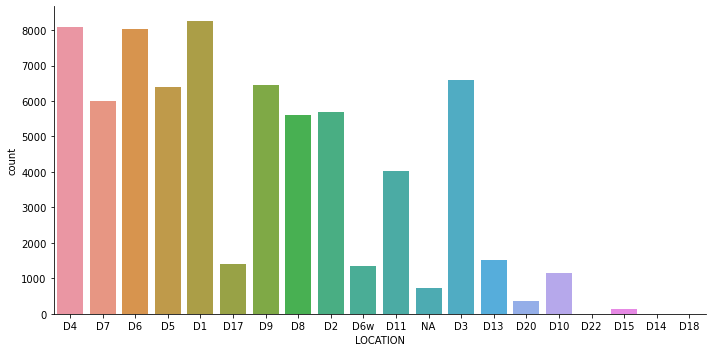

In [16]:
# Display distribution of planning applications across Dublin post codes for all dataset supplied years using a histogram
AppLocations = sns.catplot("LOCATION", data=merged_df, height=5, aspect=2, kind="count")
AppLocations.set_xticklabels

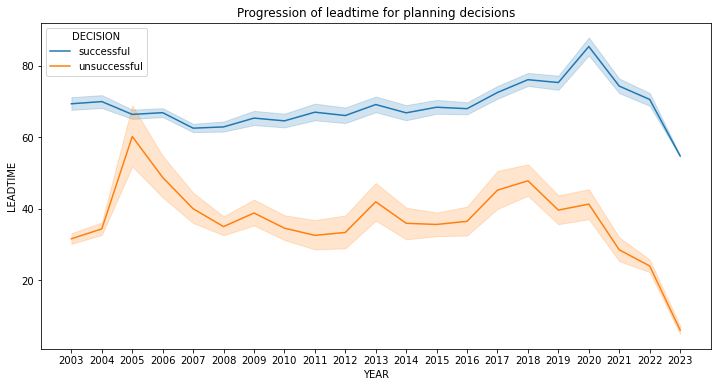

In [17]:
# Using a line plot to show leadtime over years
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="YEAR", y="LEADTIME", hue="DECISION", data=merged_df, ax=ax)
ax.set_title("Progression of leadtime for planning decisions")
ax.set_xticks(range(2003, 2024))

plt.show()

# Section 2. Descriptive Statistics

In [18]:
# Determine the mode for the Decision feature
mode = merged_df['DECISION'].mode()
print(mode)

0    successful
dtype: object


In [19]:
# Group by location and compute mean and median
print(merged_df.groupby('LOCATION')['LEADTIME'].agg([np.mean, np.median]))

               mean  median
LOCATION                   
D1        62.087957    53.0
D10       52.339071    52.0
D11       54.942284    51.0
D13       54.762311    52.0
D14       18.800000    15.0
D15       76.548872    52.0
D17       58.489347    53.0
D18        0.000000     0.0
D2        69.848063    54.0
D20       57.552486    52.0
D22       36.142857    50.0
D3        56.776953    52.0
D4        58.461805    53.0
D5        52.411360    52.0
D6        55.610966    52.0
D6w       51.056618    51.0
D7        60.290548    51.0
D8        61.390839    53.0
D9        54.546540    52.0
NA        58.107392    53.0


In [20]:
# Overall values for mean and median irrespective of location
print(merged_df['LEADTIME'].agg([np.mean, np.median]))

mean      58.300443
median    52.000000
Name: LEADTIME, dtype: float64


In [21]:
# Find the minimum and maximum values of the LEADTIME column
minlead = merged_df['LEADTIME'].min()
maxlead = merged_df['LEADTIME'].max()

# Print the results for both to discover outliers
print(f"Minimum LEADTIME value: {minlead}")
print(f"Maximum LEADTIME value: {maxlead}")

Minimum LEADTIME value: 0
Maximum LEADTIME value: 1652


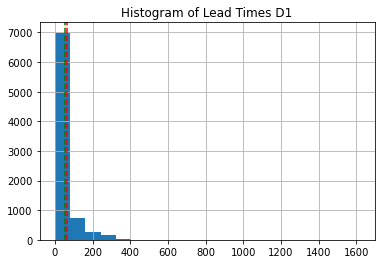

In [22]:
# Plot a histogram to show data skew
# Filter to one location D1 for illustration purposes
dubone_df = merged_df[merged_df['LOCATION'] == 'D1']


# Calculate the mean and median lead time so we can display it on the histogram
mean_lead = np.mean(dubone_df['LEADTIME'])
median_lead = np.median(dubone_df['LEADTIME'])

# plot the histogram
dubone_df['LEADTIME'].hist(bins = 20)

plt.axvline(x=mean_lead, color='red', linestyle='--', label=f'Mean: {mean_lead:.2f}')
plt.axvline(x=median_lead, color='green', linestyle='--', label=f'Median: {median_lead:.2f}')

plt.title('Histogram of Lead Times D1')
plt.show()

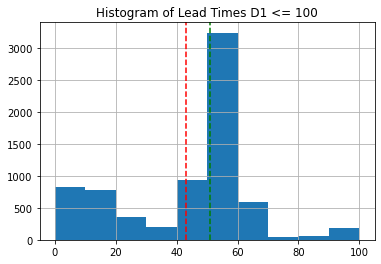

In [23]:
# Filter out all leadtime values over 100 days
# Filter out all leadtime values over 100 for location D1
filtered_df = merged_df[(merged_df['LOCATION'] == 'D1') & (merged_df['LEADTIME'] <= 100)]

# Calculate the mean and median lead time so we can display it on the histogram
mean_lead = np.mean(filtered_df['LEADTIME'])
median_lead = np.median(filtered_df['LEADTIME'])

# plot the histogram
filtered_df['LEADTIME'].hist(bins = 10)

plt.axvline(x=mean_lead, color='red', linestyle='--', label=f'Mean: {mean_lead:.2f}')
plt.axvline(x=median_lead, color='green', linestyle='--', label=f'Median: {median_lead:.2f}')

plt.title('Histogram of Lead Times D1 <= 100')
plt.show()


# Section 3. Poisson Distribution

In [24]:
# Count by year for all D1 applications
YearAvg = dubone_df.groupby('YEAR')['YEAR'].count()
# Determine the average count of applications per week
weekAvg = YearAvg.mean() / 52
weekAvgRounded = math.ceil(weekAvg)
print("Average Count per Week:", weekAvgRounded)

Average Count per Week: 8


In [25]:
# Probability of 10 applications in a week for D1
prob10 = poisson.pmf(10, 7)

print(prob10)

0.07098326865041356


In [26]:
# Probability of 3 applications in a week for D1
prob3 = poisson.pmf(3, 7)

print(prob10)

0.07098326865041356


In [27]:
# Probability of > 15 applications in a week for D1
probOver15 = 1 - poisson.cdf(14, 7)

print(probOver15)

0.005717202492495965


# Section 4. Normal Distribution

In [28]:
# Calculate the mean and standard deviation of the LEADTIME column for D1
D1mean = dubone_df['LEADTIME'].mean()
D1std = dubone_df['LEADTIME'].std()

# Print the results for STD deviation and mean for D1 location applications
print(f"Mean of LEADTIME: {D1mean:.2f}")
print(f"Standard deviation of LEADTIME: {D1std:.2f}")

Mean of LEADTIME: 62.09
Standard deviation of LEADTIME: 73.12


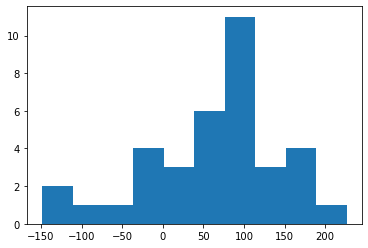

In [29]:
# Demonstrate the distribution shape for application leadtimes D1
simulatedApps1 = norm.rvs(D1mean, D1std, size=36)

# Create histogram and show distribution
plt.hist(simulatedApps1)
plt.show()

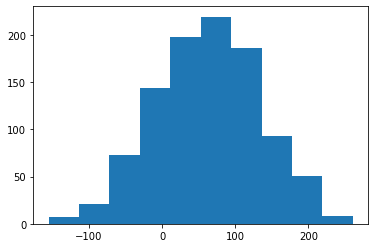

In [30]:
# Demonstrate the distribution shape for application leadtimes with a large sampling size
simulatedApps2 = norm.rvs(D1mean, D1std, size=1000)

# Create histogram and show distribution
plt.hist(simulatedApps2)
plt.show()

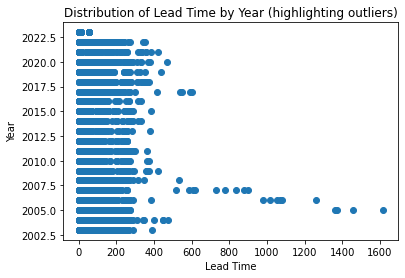

In [31]:
# use only data from D1 for year and application lead times highlighting outliers
D1Year = dubone_df['YEAR']
D1Time = dubone_df['LEADTIME']

# Create the  plot
plt.scatter(D1Time, D1Year)

# Add labels and title
plt.xlabel('Lead Time')
plt.ylabel('Year')
plt.title('Distribution of Lead Time by Year (highlighting outliers)')
plt.show()

# Data Modelling


# Section 1. Classification with Decision Tree

In [32]:
# Use year and leadtime features and put in X
X = dubone_df.iloc[:, [1, 2]].values

# Store the Decision feature in y
y = dubone_df.iloc[:, -1].values

# Display X and Y
print(X, y)

[[2010   49]
 [2003   54]
 [2003   47]
 ...
 [2023    0]
 [2023    0]
 [2023    0]] ['successful' 'successful' 'successful' ... 'unsuccessful' 'unsuccessful'
 'unsuccessful']


In [33]:
# Split the data set into Training and Testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Display the Number of rows and columns before (X, y) and after Splitting (X_train, X_test, y_train, y_test)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8254, 2), (8254,), (6603, 2), (1651, 2), (6603,), (1651,))

In [34]:
# Create and initialise an object by calling a method 'StandardScaler()'
sc = StandardScaler()

# Convert the X_train and X_test into standised format
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Display the transformed values
X_train, X_test

(array([[-0.69328089, -0.09435759],
        [ 1.3800403 ,  0.60120098],
        [-0.69328089,  0.56028577],
        ...,
        [-1.17173962, -0.14891121],
        [ 0.42312283,  0.02838804],
        [-1.33122587, -0.63989373]]),
 array([[ 1.69901279, -0.09435759],
        [ 1.22055406,  0.45117854],
        [ 0.42312283, -0.1352728 ],
        ...,
        [-1.01225338, -0.74900095],
        [-1.33122587,  2.66059988],
        [-0.69328089, -0.73536255]]))

In [35]:
# Implement decision tree
# criterion setting max_depth only

dt = DecisionTreeClassifier(max_depth=6)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])

['successful' 'successful' 'successful' 'successful' 'unsuccessful']


In [36]:
# Predict test set labels
y_pred = dt.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

Test set accuracy: 0.87


              precision    recall  f1-score   support

  successful       0.83      0.99      0.90      1007
unsuccessful       0.97      0.68      0.80       644

    accuracy                           0.87      1651
   macro avg       0.90      0.84      0.85      1651
weighted avg       0.89      0.87      0.86      1651



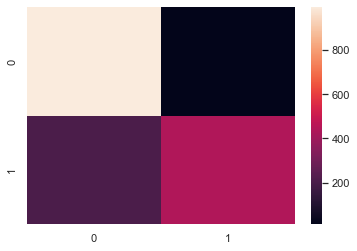

In [37]:
# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.set(font_scale=1.0)
sns.heatmap(cm, annot = False)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))

In [38]:
# Using Grid search cross validation to tune hyperparameters
# list hyperparameters
print (dt.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [39]:
# using GridSearchCV from SCIKIT learn
params_dt = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [0.04, 0.06, 0.08, 0.09],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}

# CV grid search object 
grid_dt = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='accuracy', cv=10, n_jobs=-1)

# Fit to training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(max_depth=6), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08, 0.09]},
             scoring='accuracy')

In [40]:
# Extract the best hyperparameters
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 0.08}


In [41]:
# Print the best score from GridSearchCV fit
bestScore = grid_dt.best_score_
print("GridSearchCV Best Score: {:.2f}".format(bestScore))

GridSearchCV Best Score: 0.86


# Section 2. Classification with K-NN

In [42]:
# Train and test the model on 10 different K values

neighbors = np.arange(1, 20)
train_accuracy = np.zeros(len(neighbors))
test_accuracy = np.zeros(len(neighbors))

In [43]:
for i,k in enumerate(neighbors):               
    knn = KNeighborsClassifier(n_neighbors = k)

    #Fit the model
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train) 

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      

In [44]:
# Display the test accuracy
print(test_accuracy)

[0.76801938 0.8413083  0.81465778 0.84918231 0.83949122 0.85766202
 0.85463356 0.86493035 0.85766202 0.86795881 0.86735312 0.86735312
 0.86795881 0.86795881 0.86795881 0.8691702  0.86977589 0.86856451
 0.86795881]


Minimum error:- 0.13022410660205935 at K = 16


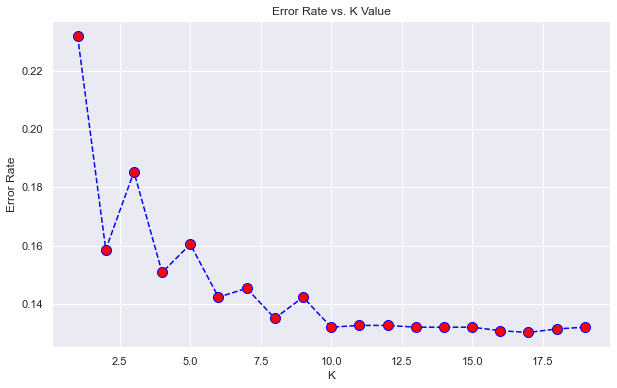

In [45]:
# Determine optimal K value by determing the minimum error rate and plotting a visualisation
# Code sample utilised from:  https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
error_rate = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

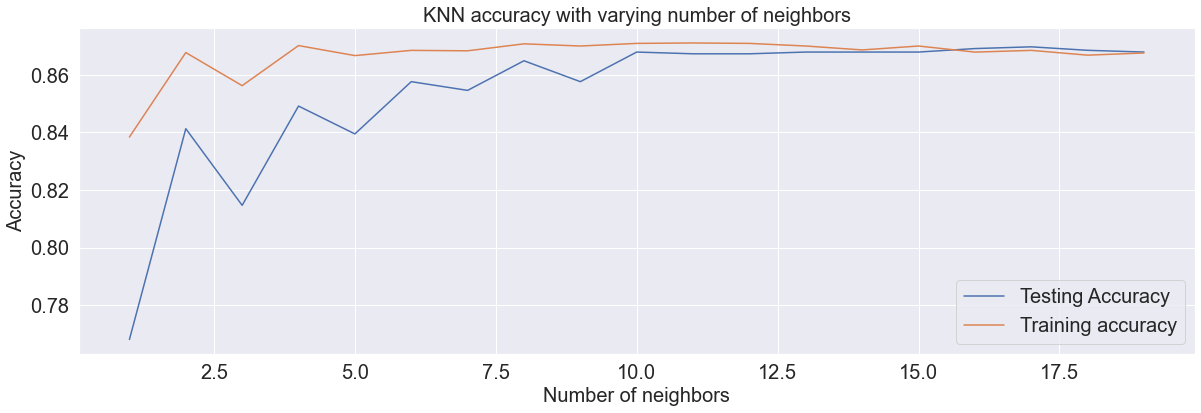

In [46]:
# Declare the size of the array
plt.figure(figsize = (20, 6))
plt.title('KNN accuracy with varying number of neighbors', fontsize = 20)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy')
plt.legend(prop = {'size': 20})
plt.xlabel('Number of neighbors', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [47]:
# Declare and initialise an object 'KNeighborsClassifier' with 16 neighbors
knn = KNeighborsClassifier(n_neighbors = 16)

# Fit the model
knn.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)

In [48]:
# Display the test accuracy
print(test_accuracy)

0.8691701998788613


              precision    recall  f1-score   support

  successful       0.83      0.99      0.90      1007
unsuccessful       0.98      0.68      0.80       644

    accuracy                           0.87      1651
   macro avg       0.90      0.84      0.85      1651
weighted avg       0.89      0.87      0.86      1651



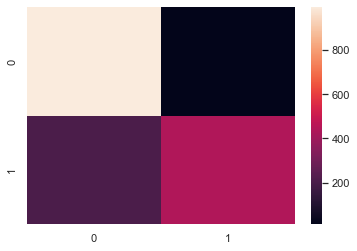

In [49]:
prediction = knn.predict(X_test)

# Display the confusion matrix
kcm = confusion_matrix(y_test, prediction)

confusion_matrix(y_test, prediction)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(kcm, annot = False)

print(classification_report(y_test, prediction))

In [50]:
# Check the dataframe for imbalanced data to just accuracy rate as predictor of 
dubone_df["DECISION"].value_counts(normalize=True)

successful      0.611946
unsuccessful    0.388054
Name: DECISION, dtype: float64

# Section 3. Regression with Simple Linear Regression

In [51]:
# Group by year and count the number of decisions and successful decisions, then sum the number of successful applications
grouped_df = merged_df.groupby('YEAR')['DECISION'].agg(['count', lambda x: (x=='successful').sum()])

# Rename the columns and reset the index
grouped_df = grouped_df.rename(columns={'count': 'total_decisions', '<lambda_0>': 'successful_decisions'}).reset_index()

# Create a new dataframe with the relevant columns from the grouped dataframe
new_df = pd.DataFrame({'YEAR': grouped_df['YEAR'], 'total_decisions': grouped_df['total_decisions'], 'successful_decisions': grouped_df['successful_decisions']})

# Print the new dataframe
print(new_df)


    YEAR  total_decisions  successful_decisions
0   2003             5130                  2941
1   2004             5098                  3167
2   2005             5354                  3298
3   2006             5774                  3609
4   2007             5760                  3652
5   2008             4534                  3001
6   2009             2740                  1869
7   2010             2460                  1705
8   2011             2011                  1422
9   2012             1927                  1345
10  2013             2079                  1559
11  2014             2320                  1694
12  2015             2732                  1987
13  2016             2967                  2144
14  2017             3263                  2367
15  2018             3424                  2459
16  2019             3564                  2375
17  2020             3011                  2010
18  2021             3407                  2217
19  2022             3659               

In [52]:
# Find the correlation number between the total number of applications and the resultant number of successful decisions
print(new_df['total_decisions'].corr(new_df['successful_decisions']))

0.9723358085442476


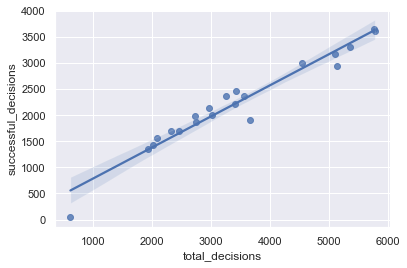

In [53]:
# Plot linear regression alongside data points and highlight the confidence interval
sns.regplot(x="total_decisions", y="successful_decisions", data=new_df)
plt.show()

In [54]:
# Fit the model and show the coefficients of intercept and slope
model_applications = ols("successful_decisions ~ total_decisions", data=new_df).fit()
print(model_applications.params)

Intercept          187.766134
total_decisions      0.596318
dtype: float64


In [55]:
# Make predictions for a sample array of values
explanatory_data = pd.DataFrame({"total_decisions": np.arange(5500, 6000)}
)
prediction_data = explanatory_data.assign(
    successful_decisions=model_applications.predict(explanatory_data)
)
print(prediction_data)

     total_decisions  successful_decisions
0               5500           3467.515438
1               5501           3468.111756
2               5502           3468.708074
3               5503           3469.304392
4               5504           3469.900710
..               ...                   ...
495             5995           3762.692876
496             5996           3763.289194
497             5997           3763.885512
498             5998           3764.481830
499             5999           3765.078148

[500 rows x 2 columns]


In [56]:
# Evaluate model performance using the coefficient of determination
print (model_applications.rsquared)

0.9454369245773957


In [57]:
# Evaluate model performance using the residual standard error
# First the MSE is calculated
mse = model_applications.mse_resid
# Then the square root of the MSE is taken to get the RSE
rse = np.sqrt(mse)
print("rse: ", rse)

rse:  205.5923080472769
